## Calling the Data Reader Class

In [ ]:
include("BBTNet/datasets/WIDERFACE.jl")
include("configs.jl")

import Random
Random.seed!(42)
data = WIDER_Data(wf_path * "train/", wf_labels_path * "train/", train=true, batch_size=batch_size, dtype=atype)
print("WIDERFACE data is read!")

## Drawing a Ground Truth Image

In [ ]:
include("./BBTNet/utils/ImageReader.jl")

train_reader = Image_Reader(true) # true for augmentation, false for only square resize

file_name = "22--Picnic/22_Picnic_Picnic_22_231.jpg"
img, bboxes = read_img(train_reader, wf_path * "train/images/" * file_name, data.bboxes[file_name], 640)
print("Image file is read: ", file_name, '\n')

In [ ]:
include("./BBTNet/utils/draw.jl")
draw_boxes_and_landmarks(img, bboxes)

## Drawing Image From Manual Data

In [ ]:
using Images

include("./BBTNet/utils/draw.jl")

data = reshape([449 330 571 479 488.906 373.643 542.089 376.442 515.031 412.83 485.174 425.893 538.357 431.491], (14, 1))
path = wf_path * "train/images/0--Parade/0_Parade_marchingband_1_849.jpg"

img = channelview(load(path))
draw_boxes_and_landmarks(img, data)

## Training the Model

In [ ]:
include("BBTNet/models/retinaface.jl")

model = RetinaFace(dtype=atype)
print("Model is loaded!")

In [ ]:
train_model(model, data, save_dir=save_dir)

## Testing the Model

#### Testing a Batch

In [ ]:
include("BBTNet/datasets/WIDERFACE.jl")
include("BBTNet/models/retinaface.jl")
include("./BBTNet/utils/draw.jl")
include("configs.jl")

Random.seed!(42)

val_data = WIDER_Data(wf_path * "val/", wf_labels_path * "val/", train=false, batch_size=batch_size, dtype=atype)
(imgs, boxes), state = iterate(val_data)

# model = RetinaFace(dtype=atype)
model = load_model(save_dir * "model_epoch2_iter6440.jld2")
c, b, l = model(imgs, nothing, mode, false, 0)

for b in 1:batch_size
    print("For Batch Image: ", b, " found ", size(c[b],1), " proposals!\n")
end

In [ ]:
# image conversion to actual shape and cpu type for the first image in the prediction
img_no = 10
img_cpu = Array(permutedims(imgs[:,:,:,img_no], (3,2,1))) ./ 255 + avg_img
combined_pts = permutedims(Array(cat(b[img_no], l[img_no], dims=2)), (2, 1))

draw_boxes_and_landmarks(img_cpu, combined_pts)

#### Testing an Individual Image

[INFO] Returning prediction results above confidence level: 0.9.


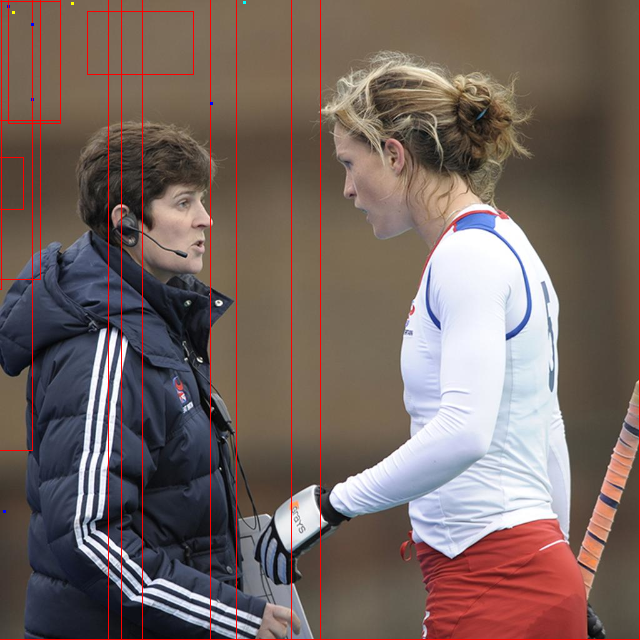

In [8]:
include("BBTNet/datasets/WIDERFACE.jl")
include("BBTNet/models/retinaface.jl")
include("./BBTNet/utils/draw.jl")
include("configs.jl")

sample_paths = [
    "18--Concerts/18_Concerts_Concerts_18_537.jpg", 
    "2--Demonstration/2_Demonstration_Demonstrators_2_688.jpg", 
    "0--Parade/0_Parade_Parade_0_652.jpg", 
    "55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_327.jpg"
]

dataset_path = wf_path * "train/" 
labels_path = wf_labels_path * "train/"
img_path = sample_paths[4]

d = WIDER_Data(dataset_path, labels_path, train=false, batch_size=1, dtype=atype)
img = read_img(d.reader, dataset_path * "images/" * img_path, nothing, img_size)
imgs = convert(atype, permutedims(reshape(img, (3, img_size, img_size, 1)), (3,2,1,4))) .* 255
img += avg_img

model = load_model(save_dir * "model_epoch4_iter6440.jld2")
c, b, l = model(imgs, nothing, mode, false, 0)

combined_pts = permutedims(Array(cat(b[1], l[1], dims=2)), (2, 1))
draw_boxes_and_landmarks(img, combined_pts)

In [6]:
length("0"^5)

5

## Saving & Loading the Model

In [ ]:
save_model(model, save_dir * "dummy_path.jld2")

In [ ]:
model = load_model(save_dir * "model_epoch1.jld2")
print("Model is loaded from a file!\n")

## Issues on Loading ResNet50 Weights

In [ ]:
include("./BBTNet/backbones/resnet.jl")
include("./BBTNet/utils/ImageReader.jl")
include("configs.jl")

img_path = "./data/cat_img.jpg"
img = convert(atype, read_img(Image_Reader(false), img_path, nothing, img_size))
img = permutedims(reshape(img, (1, 3, img_size, img_size)), (4, 3, 2, 1)) .* 255

rn = load_mat_weights(ResNet50(dtype=atype), "./weights/imagenet-resnet-50-dag.mat")
evaluate_model(rn, img)